In [67]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
import matplotlib.pyplot as plt

# Reading Data

In [28]:
# Create a SparkSession
spark = SparkSession.builder.master("local[4]").appName("ClusterShop").getOrCreate()

# Read the Excel file using Pandas
df_pandas = pd.read_excel("Online Retail.xlsx",na_values='')

# Convert the Pandas DataFrame to PySpark DataFrame
df_spark = spark.createDataFrame(df_pandas)

In [42]:
#increase the number of partitions
df_spark = df_spark.repartition(4)


# Analyzing Data

In [29]:
spark

In [41]:
#print number of partitions
print(df_spark.rdd.getNumPartitions())

10


In [30]:
df_spark.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [3]:
# Show the DataFrame
df_spark.show()

23/04/15 17:24:43 WARN TaskSetManager: Stage 0 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

### InvoiceNo
uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

In [62]:
print("Count of invoices: ", df_spark.count())
print("Count of cancelled invoices: ", df_spark.filter(df_spark.InvoiceNo.startswith('C')).count())
print('percentage of cancelled invoices: ', (df_spark.filter(df_spark.InvoiceNo.startswith('C')).count()/df_spark.count())*100)
print('number of null values: ', df_spark.filter(df_spark.CustomerID.isNull()).count())

23/04/15 23:45:15 WARN TaskSetManager: Stage 540 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/15 23:45:16 WARN TaskSetManager: Stage 546 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Count of invoices:  541909


23/04/15 23:45:16 WARN TaskSetManager: Stage 552 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Count of cancelled invoices:  9288


23/04/15 23:45:17 WARN TaskSetManager: Stage 558 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


percentage of cancelled invoices:  1.7139409015166756


23/04/15 23:45:18 WARN TaskSetManager: Stage 564 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


number of null values:  0


### StockCode
uniquely assigned to each distinct product

In [63]:
#number of items
print('number of items: ', df_spark.select('StockCode').count())
#number of unique items
print('number of unique items: ', df_spark.select('StockCode').distinct().count())
#number of null values
print('number of null values: ', df_spark.filter(df_spark.StockCode.isNull()).count())
#most popular items
df_spark.groupBy('StockCode').count().orderBy('count', ascending=False).show(10)
#least popular items
df_spark.groupBy('StockCode').count().orderBy('count', ascending=True).show(10)

23/04/15 23:48:11 WARN TaskSetManager: Stage 567 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/15 23:48:12 WARN TaskSetManager: Stage 573 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


number of items:  541909


23/04/15 23:48:13 WARN TaskSetManager: Stage 583 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


number of unique items:  4070
number of null values:  0


23/04/15 23:48:13 WARN TaskSetManager: Stage 586 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/15 23:48:14 WARN TaskSetManager: Stage 592 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+---------+-----+
|StockCode|count|
+---------+-----+
|   85123A| 2313|
|    22423| 2203|
|   85099B| 2159|
|    47566| 1727|
|    20725| 1639|
|    84879| 1502|
|    22720| 1477|
|    22197| 1476|
|    21212| 1385|
|    20727| 1350|
+---------+-----+
only showing top 10 rows



+---------+-----+
|StockCode|count|
+---------+-----+
|    84761|    1|
|   46776e|    1|
|   84612B|    1|
|    72789|    1|
|   47593b|    1|
|   90025E|    1|
|   85049c|    1|
|    22143|    1|
|        m|    1|
|   37477B|    1|
+---------+-----+
only showing top 10 rows



### Description
Product (item) name. Nominal.

In [64]:
# Count of unique values: This will give you the total number of distinct products in the dataset, as well as the number of unique product names.
print("Count of unique values: ", df_spark.select('Description').distinct().count())
#print the number of null values
print('number of null values: ', df_spark.filter(df_spark.Description.isNull()).count())
# Top products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=False).show(10)
# Bottom products by frequency
df_spark.groupBy('Description').count().orderBy('count', ascending=True).show(10)

23/04/15 23:52:09 WARN TaskSetManager: Stage 598 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/15 23:52:10 WARN TaskSetManager: Stage 608 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


Count of unique values:  4224


23/04/15 23:52:11 WARN TaskSetManager: Stage 611 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


number of null values:  0


23/04/15 23:52:12 WARN TaskSetManager: Stage 617 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|         Description|count|
+--------------------+-----+
|WHITE HANGING HEA...| 2369|
|REGENCY CAKESTAND...| 2200|
|JUMBO BAG RED RET...| 2159|
|       PARTY BUNTING| 1727|
|LUNCH BAG RED RET...| 1638|
|ASSORTED COLOUR B...| 1501|
|SET OF 3 CAKE TIN...| 1473|
|                 NaN| 1454|
|PACK OF 72 RETROS...| 1385|
|LUNCH BAG  BLACK ...| 1350|
+--------------------+-----+
only showing top 10 rows



+--------------------+-----+
|         Description|count|
+--------------------+-----+
|SET OF THREE VINT...|    1|
|     damages/display|    1|
|     Damages/samples|    1|
|PINK PAINTED KASH...|    1|
|   rusty thrown away|    1|
|Printing smudges/...|    1|
|   Thrown away-rusty|    1|
|  code mix up? 84930|    1|
|     samples/damages|    1|
|BAROQUE BUTTERFLY...|    1|
+--------------------+-----+
only showing top 10 rows



### Quantity
The quantities of each product (item) per transaction. Numeric.


23/04/16 00:01:02 WARN TaskSetManager: Stage 701 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/16 00:01:03 WARN TaskSetManager: Stage 707 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+
|summary|         Quantity|
+-------+-----------------+
|  count|           541909|
|   mean| 9.55224954743324|
| stddev|218.0811578502345|
|    min|           -80995|
|    max|            80995|
+-------+-----------------+



23/04/16 00:01:06 WARN TaskSetManager: Stage 710 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.
23/04/16 00:01:07 WARN TaskSetManager: Stage 716 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


percentage of transactions with negative quantities:  1.9604767590130447


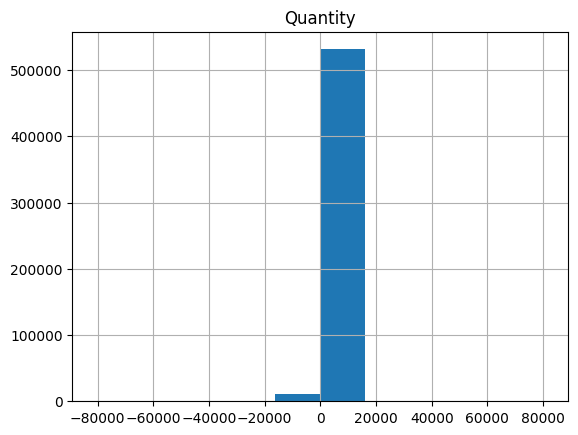

In [70]:
df_spark.select('Quantity').describe().show()
df_spark.select('Quantity').toPandas().hist()
print('percentage of transactions with negative quantities: ', (df_spark.filter(df_spark.Quantity < 0).count()/df_spark.count())*100)

In [77]:
df_spark.groupBy('Country').sum('Quantity').orderBy('sum(Quantity)', ascending=False).show(5)
df_spark.groupBy('StockCode').sum('Quantity').orderBy('sum(Quantity)', ascending=False).show(5)

23/04/16 00:07:24 WARN TaskSetManager: Stage 770 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+--------------+-------------+
|       Country|sum(Quantity)|
+--------------+-------------+
|United Kingdom|      4263829|
|   Netherlands|       200128|
|          EIRE|       142637|
|       Germany|       117448|
|        France|       110480|
+--------------+-------------+
only showing top 5 rows



23/04/16 00:07:24 WARN TaskSetManager: Stage 776 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+---------+-------------+
|StockCode|sum(Quantity)|
+---------+-------------+
|    22197|        56450|
|    84077|        53847|
|   85099B|        47363|
|   85123A|        38830|
|    84879|        36221|
+---------+-------------+
only showing top 5 rows



In [80]:
from pyspark.sql.functions import month 
#TOP FIVE MONTHES BY SUM OF QUANTITY
df_spark.groupBy(month('InvoiceDate')).sum('Quantity').orderBy('sum(Quantity)', ascending=False).show(5)

23/04/16 00:08:57 WARN TaskSetManager: Stage 794 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+------------------+-------------+
|month(InvoiceDate)|sum(Quantity)|
+------------------+-------------+
|                11|       740286|
|                10|       570532|
|                12|       568561|
|                 9|       549817|
|                 8|       406199|
+------------------+-------------+
only showing top 5 rows



In [14]:
import math
# count the number of missing values in the Description column
print(df_spark.filter(df_spark['Description'].isNull()).count())
# filter out the missing values using map 
df_spark_filtered = df_spark.rdd.map(lambda x: x if not math.isnan( x['CustomerID'])  else None).filter(lambda x: x is not None).toDF()



23/04/15 19:28:31 WARN TaskSetManager: Stage 20 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


0


23/04/15 19:28:32 WARN TaskSetManager: Stage 23 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


In [7]:
df_spark_filtered.describe().show()

23/04/15 17:48:06 WARN TaskSetManager: Stage 8 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----------------+------------------+--------------------+-----------------+------------------+------------------+-----------+
|summary|        InvoiceNo|         StockCode|         Description|         Quantity|         UnitPrice|        CustomerID|    Country|
+-------+-----------------+------------------+--------------------+-----------------+------------------+------------------+-----------+
|  count|           406829|            406829|              406829|           406829|            406829|            406829|     406829|
|   mean|560617.1266447864|27430.341352504624|                null|12.06130339774205|3.4604710185376426|15287.690570239585|       null|
| stddev|13106.16769474081|16403.570452626223|                null|248.6933700188252| 69.31516172321443|1713.6003033215966|       null|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|           -80995|               0.0|           12346.0|  Australia|
|    max|          C581569|              POST|ZI

In [8]:
# convert the InvoiceDate column to a date
from pyspark.sql.functions import to_date
df_spark_filtered = df_spark_filtered.withColumn("InvoiceDate", to_date(df_spark_filtered.InvoiceDate, 'MM/dd/yyyy'))
    

In [9]:

from pyspark.sql.functions import col
from pyspark.sql.functions import round
from pyspark.sql.functions import month

# create a new column called TotalCost
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", col("Quantity") * col("UnitPrice"))

# round the TotalCost column to 2 decimal places
df_spark_filtered = df_spark_filtered.withColumn("TotalCost", round(df_spark_filtered.TotalCost, 2))

# create a new column called InvoiceMonth
df_spark_filtered = df_spark_filtered.withColumn("InvoiceMonth", month(df_spark_filtered.InvoiceDate))


df_spark_filtered.show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+---------+------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|TotalCost|InvoiceMonth|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+---------+------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|   17850.0|United Kingdom|     15.3|          12|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|    20.34|          12|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|   17850.0|United Kingdom|     22.0|          12|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|    20.34|          12|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|    20.34|          12|
|   536365|    2

23/04/15 17:48:50 WARN TaskSetManager: Stage 11 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


In [10]:
# Import necessary functions
from pyspark.sql.functions import count, mean, sum

# Define a function to aggregate the data by customer ID and invoice month
def aggregate_data_by_customer(row):
    # Extract the customer ID and invoice month from the row
    customerID, invoiceMonth, invoiceNo, totalCost = row["CustomerID"], row["InvoiceMonth"], row["InvoiceNo"], row["TotalCost"]
    # Convert the total cost to a float
    totalCost = float(totalCost)
    # Return a tuple containing the customer ID, invoice month, and a dictionary with the aggregated values
    return ((customerID, invoiceMonth), {"TotalPurchases": 1, "TotalRevenue": totalCost, "AvgRevenuePerPurchase": totalCost})

# Define a function to combine the aggregated data for each customer
def combine_customer_data(data1, data2):
    # Combine the dictionaries for the two sets of aggregated data
    combined_data = {k: data1.get(k, 0) + data2.get(k, 0) for k in set(data1) | set(data2)}
    # Return the combined data
    return combined_data

# Map the data using the aggregate_data_by_customer() function
mapped_data = df_spark_filtered.rdd.map(aggregate_data_by_customer)

# Reduce the data using the combine_customer_data() function
reduced_data = mapped_data.reduceByKey(combine_customer_data)

# Convert the reduced data to a DataFrame
df_customer = reduced_data.map(lambda x: (x[0][0], x[0][1], x[1]["TotalPurchases"], x[1]["TotalRevenue"], x[1]["AvgRevenuePerPurchase"])).toDF(["CustomerID", "InvoiceMonth", "TotalPurchases", "TotalRevenue", "AvgRevenuePerPurchase"])

# show the data frame   
df_customer.show()  

23/04/15 17:49:02 WARN TaskSetManager: Stage 12 contains a task of very large size (8485 KiB). The maximum recommended task size is 1000 KiB.


+----------+------------+--------------+------------------+---------------------+
|CustomerID|InvoiceMonth|TotalPurchases|      TotalRevenue|AvgRevenuePerPurchase|
+----------+------------+--------------+------------------+---------------------+
|   17850.0|          12|           297| 5391.210000000009|    5391.210000000009|
|   16098.0|          12|            12|430.59999999999997|   430.59999999999997|
|   18074.0|          12|            13|             489.6|                489.6|
|   16250.0|          12|            14|226.14000000000001|   226.14000000000001|
|   15862.0|          12|           111| 527.3799999999999|    527.3799999999999|
|   16218.0|          12|            28|471.29999999999995|   471.29999999999995|
|   12838.0|          12|            59|390.78999999999985|   390.78999999999985|
|   13758.0|          12|            24|            718.85|               718.85|
|   13694.0|          12|            70|            6016.2|               6016.2|
|   16210.0|    